<a href="https://colab.research.google.com/github/ClarenceKaranja/ROBUST-PORTFOLIO-OPTIMIZATION-WITH-RISK-DECAY/blob/main/markowitz_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly_express
!pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
import pandas_datareader as web
from datetime import datetime as dt, tim edelta as td
from scipy import optimize

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import yfinance as yf
from datetime import datetime as dt, timedelta as td

end = dt.today()
start = end - td(days=2000)
stocks = 'AMZN TSLA META MSFT'.split()

# Fetch historical data
df = yf.download(stocks, start=start, end=end)

# Print the DataFrame
print(df)

[*********************100%%**********************]  4 of 4 completed
             Adj Close                                           Close  \
                  AMZN        META        MSFT        TSLA        AMZN   
Date                                                                     
2018-05-30   81.244499  187.669998   93.199783   19.448000   81.244499   
2018-05-31   81.481003  191.779999   93.096191   18.982000   81.481003   
2018-06-01   82.077003  193.990005   94.932869   19.454666   82.077003   
2018-06-04   83.263496  193.279999   95.761734   19.782667   83.263496   
2018-06-05   84.817497  192.940002   96.251511   19.408667   84.817497   
...                ...         ...         ...         ...         ...   
2023-11-13  142.589996  329.190002  365.937256  223.710007  142.589996   
2023-11-14  145.800003  336.309998  369.519989  237.410004  145.800003   
2023-11-15  143.199997  332.709991  369.670013  242.839996  143.199997   
2023-11-16  142.830002  334.190002  376.170

In [3]:
# remove multilevel
df.columns = ['_'.join(col) for col in df.columns]

# Just study adj close
df = df.iloc[:,:4]

In [4]:
df.head()

,Adj Close_AMZN,Adj Close_META,Adj Close_MSFT,Adj Close_TSLA
Date,,,,
2018-05-30,81.244499,187.669998,93.199783,19.448000
2018-05-31,81.481003,191.779999,93.096191,18.982000
2018-06-01,82.077003,193.990005,94.932869,19.454666
2018-06-04,83.263496,193.279999,95.761734,19.782667
2018-06-05,84.817497,192.940002,96.251511,19.408667


In [5]:
px.line(df * 100 / df.iloc[0])

In [6]:
ret_port = df.pct_change()
px.line(ret_port)

# MEAN VARIANCE OPTIMIZATION/ MVO

In [7]:
#Setting Random Seed, When you set a random seed, it ensures that if you run the same code again, you'll get the same random numbers.
np.random.seed(1)

# Generating Random Weights
#This line generates an array of random numbers (weights) for each security. (4, 1) specifies that you want a 4x1 matrix (column vector) of random numbers
weights = np.random.random((4,1))

# Normalizing Weights
# line normalizes the weights so that they sum up to 1. This makes them represent proportions of the total investment.
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# Log Returns Calculation
log_ret = np.log(df / df.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk) Calculation
# This calculates the expected volatility of the portfolio, a measure of risk. It involves the covariance matrix of log returns.
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')

# Sharpe ratio Calculation:
# This calculates the Sharpe ratio, a measure of the risk-adjusted return. It's the ratio of expected return to expected volatility.
sr = exp_ret / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [2.89640161e-01 5.00297106e-01 7.94383512e-05 2.09983296e-01]

Expected return of the portfolio is : 0.17936659602816846

Volatility of the portfolio: 0.3739847473773172

Sharpe ratio of the portfolio: 0.479609388580769


Monte Carlo Simulation

In [26]:
# setting up the parameters for the Monte Carlo Simulation:
# number of simulation
n = 50_000

# Initialization of Arrays
# initialize arrays to store the weights, volatility, Sharpe ratio, and return for each simulated portfolio.
port_weights = np.zeros(shape=(n,len(df.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

In [28]:
# Number of Securities (the number of securities in the dataset)
num_securities = len(df.columns)
num_custom_securities

4

In [29]:
# This loop performs the Monte Carlo Simulation:
for i in range(n):
    # Randomly Generate Portfolio Weights
    weights = np.random.random(4)

    # normalizes the weights to ensure that the sum is equal to 1
    weights /= np.sum(weights)

    # stores the generated weights for each security in the port_weights array.
    port_weights[i,:] = weights

    # calculates the expected return for the portfolio based on the randomly generated weights.
    exp_ret = log_ret.mean().dot(weights)*252

    # stores the calculated expected return in the port_return array.
    port_return[i] = exp_ret

    # calculates the expected volatility (risk) for the portfolio based on the randomly generated weights.
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))

    # stores the calculated expected volatility in the port_volatility array.
    port_volatility[i] = exp_vol

    #  calculates the Sharpe ratio for the portfolio based on the randomly generated weights.
    sr = exp_ret / exp_vol

    # stores the calculated Sharpe ratio in the port_sr array.
    port_sr[i] = sr

In [34]:
# identifys the portfolio with the maximum Sharpe Ratio (SR) from the Monte Carlo Simulation results
# Index of Maximum Sharpe Ratio
# finds the maximum Sharpe Ratio from the array port_sr, which stores the Sharpe Ratios for each simulated portfolio.
max_sr = port_sr.max()
print(max_sr)
# Index of Maximum Sharpe Ratio:
# finds the index (or position) of the maximum Sharpe Ratio in the array port_sr. This index will be used to retrieve the corresponding values for return and volatility.
ind = port_sr.argmax()
print(ind)
# Return and Volatility at Maximum Sharpe Ratio
# lines extract the return and volatility of the portfolio that corresponds to the maximum Sharpe Ratio.
max_sr_ret = port_return[ind]
print(max_sr_ret)

max_sr_vol = port_volatility[ind]
print(max_sr_vol)

0.8911902636729696
9699
0.2858941837939796
0.3208003895999598


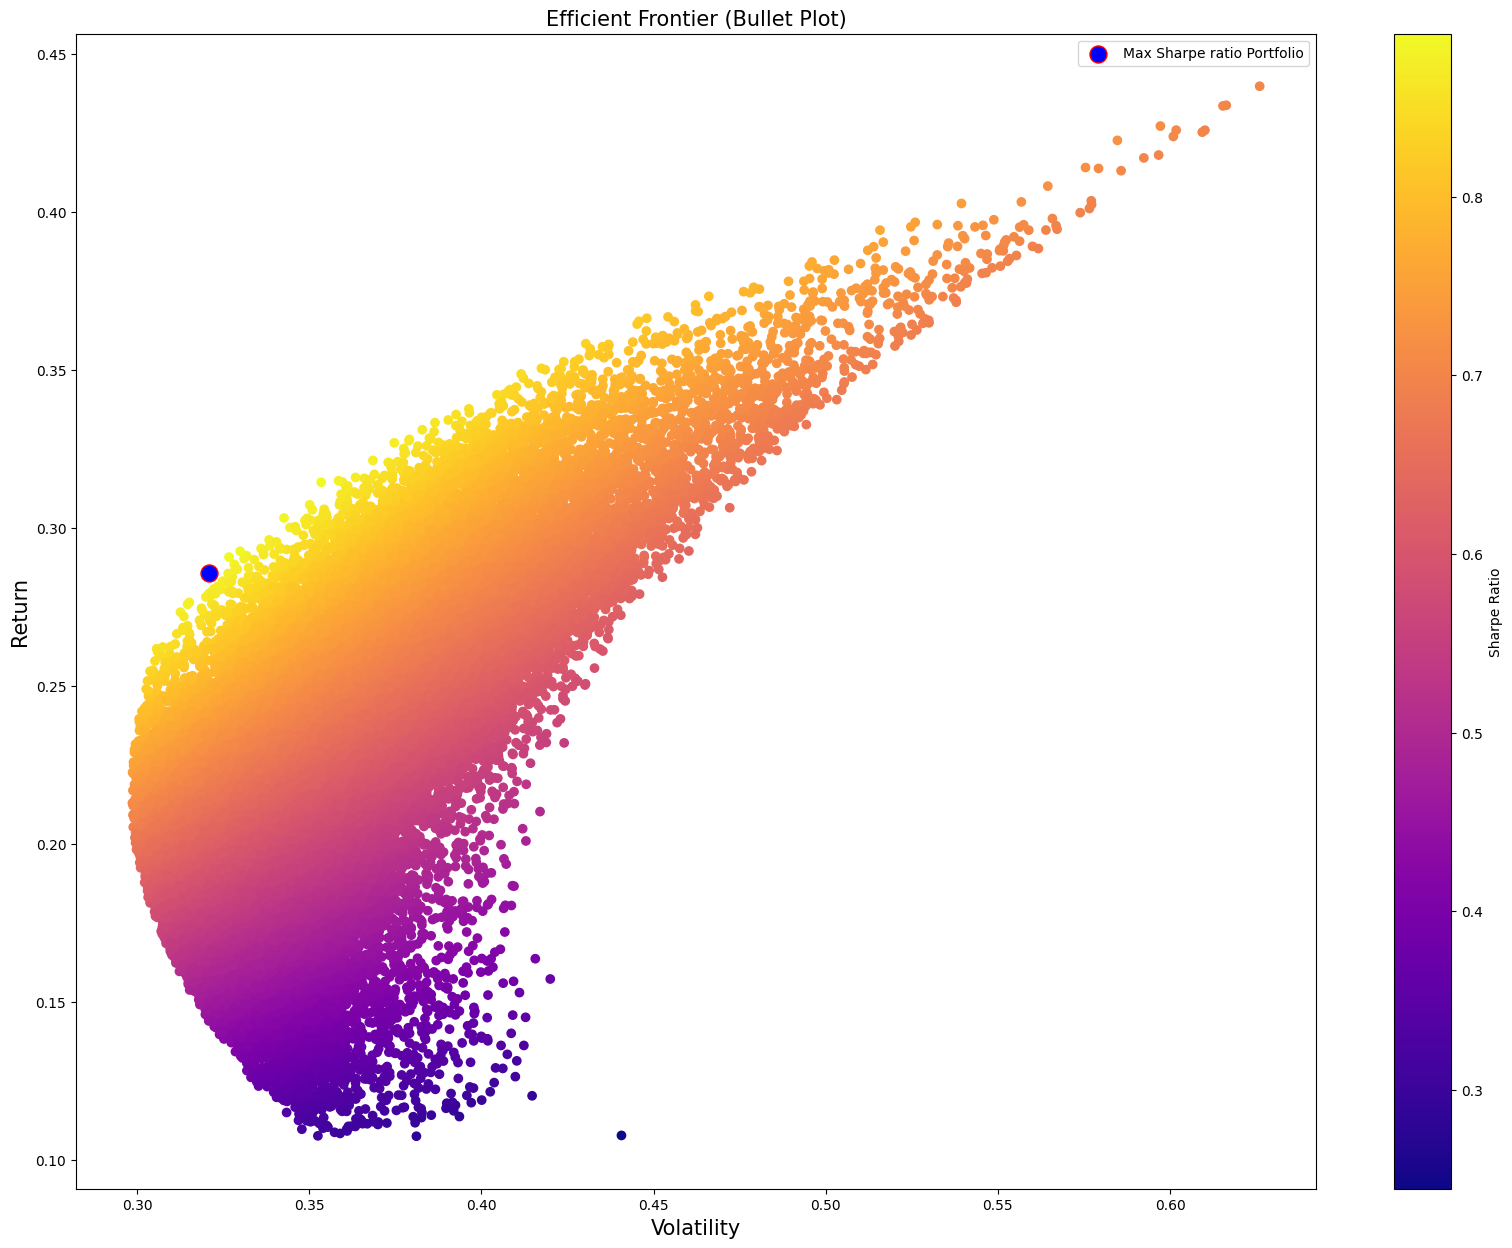

In [32]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();

THE PORTFOLIO YOU SHOULD HAVE IF YOU ARE USING THE MVO

In [25]:
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

# best portfolio return
print(f'\nMarkowitz(mvo) optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

0.35 % of AMZN should be bought.
0.02 % of TSLA should be bought.
82.75 % of META should be bought.
16.87 % of MSFT should be bought.

Markowitz(mvo) optimal portfolio return is : 28.58% with volatility 0.3187562964768978


## MEAN VARIANCE OPTIMIZATION WITH RISK DECAY


In [ ]:
# Function to calculate the risk decay based on the provided model
def calculate_risk_decay(initial_risk, decay_rate, time):
    return initial_risk * np.exp(-decay_rate * time)

# Set the decay rate
custom_decay_rate = 0.05

# Modified function to get expected return and volatility considering risk decay
def get_ret_vol_sr_custom(weights, time):
    weights = np.array(weights)
    log_returns = np.log(df / df.shift(1))
    decayed_risk = calculate_risk_decay(log_returns.std(), custom_decay_rate, time)
    ret = log_returns.mean().dot(weights) * 252
    vol = np.sqrt(weights.T.dot(252 * (log_returns.cov() * decayed_risk).dot(weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

In [ ]:
# Number of simulations
num_simulations = 50_000

# Initialize arrays to store results
custom_port_weights = np.zeros(shape=(num_simulations, len(df.columns)))
custom_port_volatility = np.zeros(num_simulations)
custom_port_sr = np.zeros(num_simulations)
custom_port_return = np.zeros(num_simulations)

In [ ]:
# Number of securities
num_custom_securities = len(df.columns)
print(num_custom_securities)
# Set the initial date and time
custom_start_date = dt.today() - td(days=2000)
print(custom_start_date)

Monte Carlo Simulation

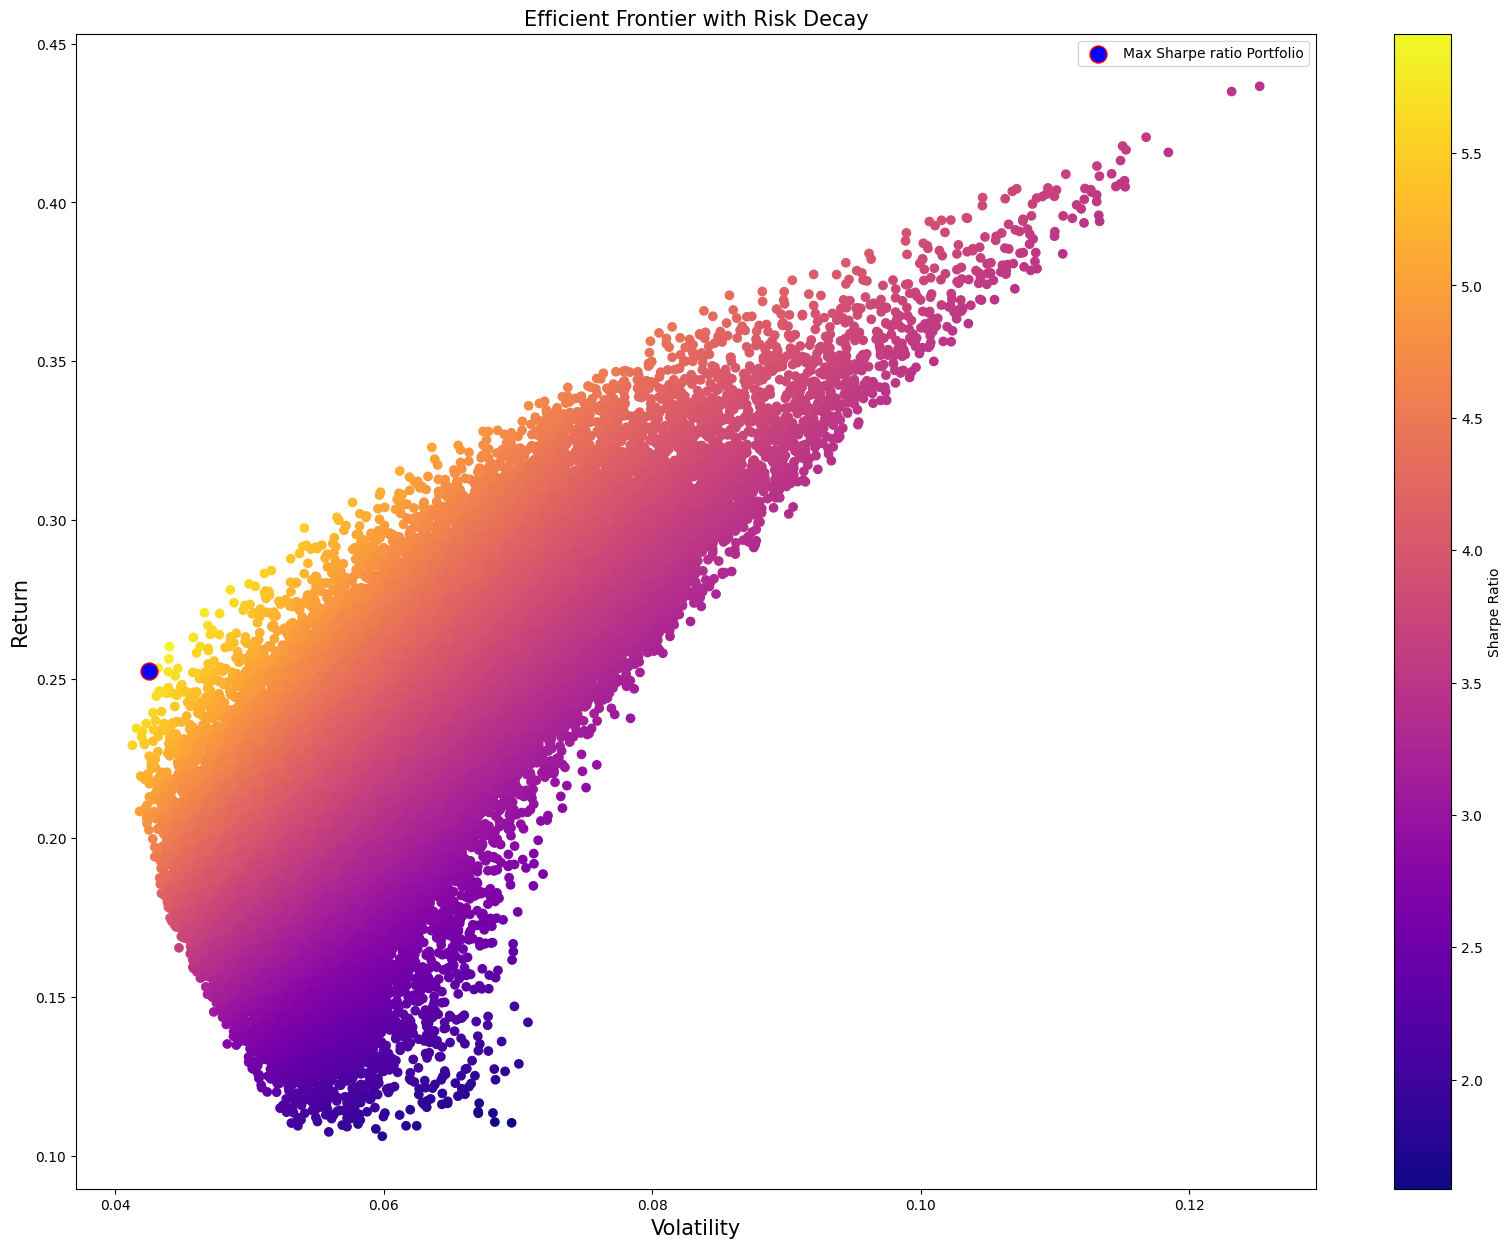

In [12]:
# Monte Carlo Simulation
for i in range(num_simulations):
    # Weight each security
    custom_weights = np.random.random(4)
    custom_weights /= np.sum(custom_weights)
    custom_port_weights[i, :] = custom_weights

    # Calculate the time decay
    custom_time_decay = i / num_simulations  # Adjust as needed based on the desired time decay logic

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    custom_exp_ret = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[0]
    custom_port_return[i] = custom_exp_ret

    # Exp Volatility (Risk)
    custom_exp_vol = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[1]
    custom_port_volatility[i] = custom_exp_vol

    # Sharpe ratio
    custom_sr = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[2]
    custom_port_sr[i] = custom_sr


In [ ]:
# Index of max Sharpe Ratio
custom_max_sr = custom_port_sr.max()
custom_ind = custom_port_sr.argmax()

# Return and Volatility at Max SR
custom_max_sr_ret = custom_port_return[custom_ind]
custom_max_sr_vol = custom_port_volatility[custom_ind]

In [ ]:
# Plot the efficient frontier
plt.figure(figsize=(20, 15))
plt.scatter(custom_port_volatility, custom_port_return, c=custom_port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier with Risk Decay', fontsize=15)
plt.scatter(custom_max_sr_vol, custom_max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max Sharpe ratio Portfolio')
plt.legend()
plt.show()

In [13]:
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

# best portfolio return
print(f'\nMarkowitz optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

# Display weights for the optimal portfolio
for weight, stock in zip(custom_port_weights[ind], stocks):
    print(f'{round(weight * 100, 2)}% of {stock} should be bought.')

# Display the optimal portfolio return
print(f'\nMarkowitz with risk decay optimal portfolio return is: {round(custom_max_sr_ret * 100, 2)}% with volatility \
{custom_max_sr_vol}')


0.35 % of AMZN should be bought.
0.02 % of TSLA should be bought.
82.75 % of META should be bought.
16.87 % of MSFT should be bought.

Markowitz optimal portfolio return is : 28.58% with volatility 0.3187562964768978
26.68% of AMZN should be bought.
41.84% of TSLA should be bought.
18.88% of META should be bought.
12.6% of MSFT should be bought.

Markowitz with risk decay optimal portfolio return is: 25.27% with volatility 0.042467710075745714
